In [2]:
import numpy as np
import pandas as pd
#!pip install nolds
#!pip install git+https://github.com/neuropsychology/NeuroKit.py#egg=neurokit
from pandas import ExcelWriter
from pandas import ExcelFile
import os , sys
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import norm
import matplotlib.mlab as mlab
import neurokit as nk
import neurokit2 as nk2
#!git clone https://github.com/davidhallac/TICC.git
from TICC_solver import TICC
import re
import seaborn as sns
cwd = os.getcwd()
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#sns.set(rc={'figure.figsize':(200,200)})
sns.set(style="white")
sns.set_palette("Set2")



In [4]:
files = glob.glob('*[0-9].txt*')

raw_traj = {}

filtered_traj = {}

for file in files:
    raw_traj[file[:-4]] = np.loadtxt(file, dtype='i', delimiter=',')


switch = [253]

#Seperate trajectories into control and biased. 
traj_binned_raw = {}
#bins = ['heat','cont','Stir_Heat']
#bins = ['cont_FrameRate10', 'heat_FrameRate10', 'heat_FrameRate5', 'heat_FrameRate2p5', 'cont_FrameRate5']
#bins = ['Naringenin40','heat']
#bins = ['Naringenin40']
bins = ['switch']
for b in bins:
    traj_binned_raw[b] = {}


#For now, ignore the size and perimeter data and just look at centroid position.
for key in raw_traj.keys():
    for bin_name in bins:
        if re.match('^[0-9]*$', key): 
            if int(key) in vars()[bin_name]:
                traj_binned_raw[bin_name][key] = raw_traj[key][:,0:2]
                filtered_traj[key] = raw_traj[key]
                break
        else: 
            break

            
# FOR  KYMOGRAPHS WE DON'T REALLY NEED THE RMSD AND STUFF

def Swap(arr, start_index, last_index):
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]


thermolist = pd.read_excel('Experiment_List.xlsx', sheet_name='Sheet1')
traj_binned = {}



for b in bins:  
    traj_binned[b] = {}

    for key in traj_binned_raw[b].keys(): 
        temp1 = traj_binned_raw[b][key]
        
        
        #If the bin is cont or heat, convert the higher frame rate trials to FR = 30s
        if b == 'cont':
            if int(key) in [103,105]:
                temp1 = temp1[0::3]
            elif int(key) in [111]:
                temp1 = temp1[0::6]
        elif b == 'heat':
            if int(key) in [107]:
                temp1 = temp1[0::3]
            elif int(key) in [109]:
                temp1 = temp1[0::6]   
            elif int(key) in [110]:
                temp1 = temp1[0::12] 
            
        traj_binned[b][key] = np.zeros((len(temp1[:,0]),3))
        trialnum = int(key)
        indlist = np.where(thermolist['Trial'] == trialnum)
        ind = indlist[0][0]
        pixel_conv = thermolist['Pixel Conversion'][ind]
        axis = thermolist['Axis'][ind]
        


        camnum = thermolist['Cam'][ind]
        if pixel_conv != 0:
            print('px conv:', pixel_conv, ' trial: ', key)
            temp1 = temp1 * pixel_conv #Si Wafer PVC pipe setup, cam2 with hot plate
            
        elif camnum == 1:
            temp1 = temp1 * 50800/1864000  #Si Wafer PVC pipe setup
        elif camnum ==2:
            temp1 = temp1 * 50800/966000 #Si Wafer PVC pipe setup
        elif camnum ==3:
            temp1 = temp1 * 50800/834000 #Si Wafer PVC pipe setup
        else:
            continue
            
        
        if axis == 'yp':
            temp1[:,1] = temp1[:,1] * -1
        elif axis == 'xp':
            Swap(temp1, 0, 1)
            temp1[:,1] = temp1[:,1] * -1
        elif axis == 'xn':
            Swap(temp1, 0, 1)
        
        #Third column is time
        traj_binned[b][key][:,2] = np.linspace(0,0.5*(len(temp1[:,0])-1),len(temp1[:,0]))    
        traj_binned[b][key][:,:2] = temp1



px conv: 0.06134969325153374  trial:  253


352
[ -2.08588957   6.87116564 176.        ]


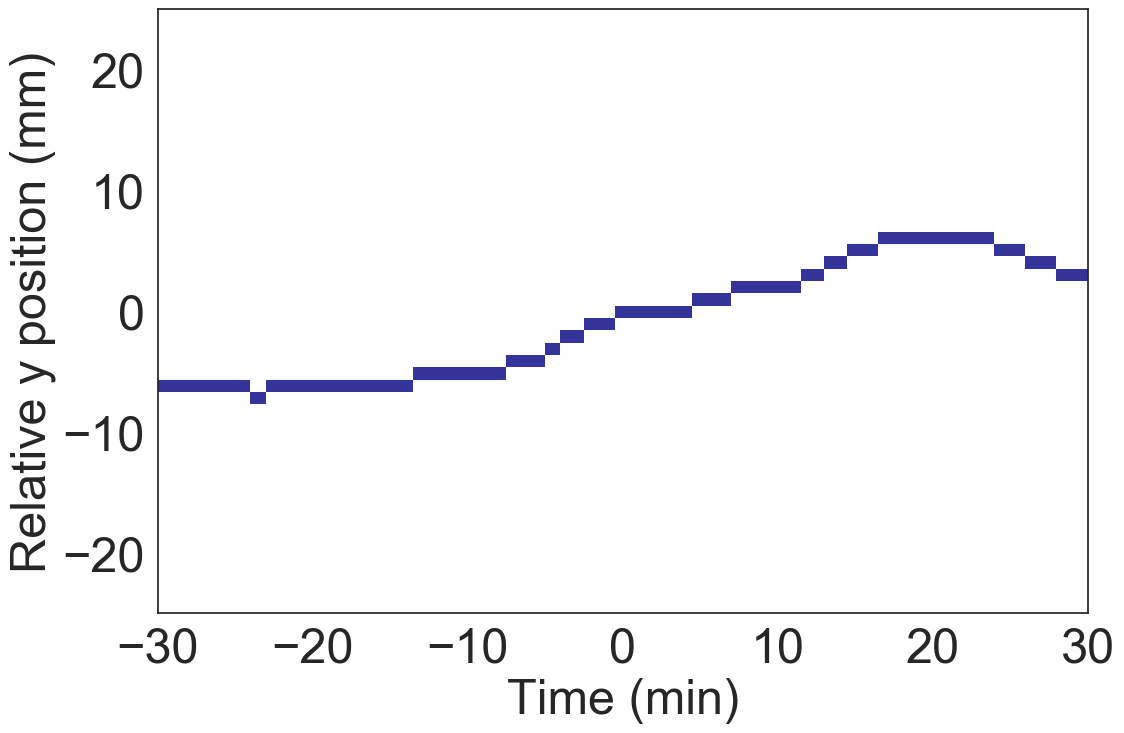

In [9]:
switch = [253]
switch_frame = [582-230]

#NUMBER OF FRAMES PRIOR TO AND AFTER GRADIENT SWITCH
l_kymo = 60


for b in bins:
    templist = []
    concat = np.zeros([l_kymo*2+1, len(traj_binned[b].values())])
    
    
    #concatenate (t, y position) across all trials in a certain condition
    c = 0
    for trial in switch:
        array = traj_binned['switch'][str(trial)]
        frame = switch_frame[c] 
        c = c+1
        print(frame)
        print(array[frame])
        temp_traj = array[frame-l_kymo:frame+l_kymo+1,1]
        #center the traj at the position when the gradient change occured
        middleIndex = (len(temp_traj) - 1) / 2
        #print (middleIndex)
        #print (temp_traj[int(middleIndex)])
        temp_traj = temp_traj - temp_traj[int(middleIndex)]
        templist.append(temp_traj)  
    
        for i in range(len(templist)):
            concat[:, i-1] = templist[i][:]


    #create the x and y axes
    x = np.linspace(-l_kymo/2,l_kymo/2,l_kymo*2+1)   #time (min)
    y = np.linspace(-25, 25, 50)   #position relative to start (mm)
    [X, Y] = np.meshgrid(x, y)
    #create empty ndarray with dimensions (y-1, x-1) columns flipped because i want the position to be the y axis 
    kymograph = np.zeros([len(y-1), len(x-1)])
    
    #absolute total num of trajectories in the condition
    absolute_total_traj = len(traj_binned[b].values())
    #print(absolute_total_traj)
    
    for i in range(len(kymograph[0,:])-1):   #TIMEPOINT
        total_traj = absolute_total_traj
        # find the total number of trajectories at that timepoint
        # take the total_traj and minus one for each organism that finished moving already
        time_slice = concat[i, :]
        for entry in time_slice:
            if entry == filler:
                total_traj = total_traj - 1
        
        for j in range(len(kymograph[:,0])-1):
            counter = 0
            ymin = y[j]
            ymax = y[j+1]
            
            
            for entry in time_slice:
                if entry >= ymin and entry < ymax:
                    counter = counter +1 
            kymograph[j,i] = counter / total_traj
            
        #print(total_traj)
    plt.figure()
    plt.xlabel('Time (min)', fontsize = 35)
    plt.ylabel('Relative y position (mm)', fontsize = 35)
    plt.xticks (fontsize = 35)
    plt.yticks (fontsize = 35)
    c = plt.pcolormesh(X , Y, kymograph, cmap = 'terrain_r')            
    #clb = plt.colorbar(label = 'Fraction of organisms')
    #clb.ax.tick_params(labelsize=35) 
    #clb.set_label(label = 'Fraction of organisms', size=35)
    title = 'KYMOGRAPH_' + b + '.png'
    plt.savefig(cwd+'/PaperFigs/' + title, bbox_inches="tight")
